# Data Visualization for Ionosphere Forecasting (Improved)
This notebook visualizes the data loaded from the sequence dataset with L1 conditions.
**Improvements:** Fixed white dot in polar plots, better title spacing, and dual GIF animation.

In [1]:
# Set matplotlib to high DPI for better quality images - FIX PIXELATION
import matplotlib
matplotlib.rcParams['figure.dpi'] = 150
matplotlib.rcParams['savefig.dpi'] = 300
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams['axes.facecolor'] = 'white'

import sys
import os
sys.path.append('/mnt/nas05/data01/francesco/progetto_simone/ionosphere')

import numpy as np
import matplotlib.pyplot as plt
import torch
from src.data.dataset import get_sequence_data_objects
from util import plot_polar_ionosphere_single, plot_polar_ionosphere_comparison
import imageio
from IPython.display import Image, display, HTML
import pandas as pd
from matplotlib.patches import Circle
import io
from PIL import Image as PILImage

/mnt/nas05/data01/francesco/progetto_simone/ionosphere/src/vit.py:26: FutureWarning: xformers.components is deprecated and is not maintained anymore. It might be removed in a future version of xFormers 
  import xformers.components.attention.core as xfa


## Configuration Parameters
Modify these parameters to match your training configuration:

In [4]:
# Configuration parameters - MODIFY THESE AS NEEDED
SEQUENCE_LENGTH = 16
PREDICT_STEPS = 1
CSV_PATH = "/mnt/nas05/data01/francesco/sdo_img2img/sde_mag2mag_v2/progetto_simone/data/merged_params_solar_wind.csv"
BATCH_SIZE = 1  # Small batch for visualization
NORM_TYPE = "absolute_max"  # "absolute_max" or "mean_sigma_tanh"
USE_L1_CONDITIONS = True

# Derived parameters
CONDITIONING_LENGTH = SEQUENCE_LENGTH - PREDICT_STEPS

print(f"📊 Configuration:")
print(f"  Sequence Length: {SEQUENCE_LENGTH}")
print(f"  Conditioning Frames: {CONDITIONING_LENGTH}")
print(f"  Prediction Frames: {PREDICT_STEPS}")
print(f"  Using L1 Conditions: {USE_L1_CONDITIONS}")
print(f"  Normalization: {NORM_TYPE}")

📊 Configuration:
  Sequence Length: 16
  Conditioning Frames: 15
  Prediction Frames: 1
  Using L1 Conditions: True
  Normalization: absolute_max


## Load Dataset

In [5]:
# Load the dataset
print("Loading dataset...")
train_dataset, train_sampler, train_dl = get_sequence_data_objects(
    csv_path=CSV_PATH,
    transform_cond_csv=None,  # Not needed when using L1 conditions
    batch_size=BATCH_SIZE,
    distributed=False,
    num_data_workers=2,
    split='train',
    seed=42,
    sequence_length=SEQUENCE_LENGTH,
    normalization_type=NORM_TYPE,
    use_l1_conditions=USE_L1_CONDITIONS,
)

print(f"✅ Dataset loaded: {len(train_dataset)} sequences")
print(f"✅ DataLoader created with batch size: {BATCH_SIZE}")

Loading dataset...
✅ Dataset loaded: 10604 sequences
✅ DataLoader created with batch size: 1


## Get Sample Batch

In [27]:
# Get a sample batch
batch_iter = iter(train_dl)
sample_batch = next(batch_iter)

data_seq, cond_seq = sample_batch

print(f"📦 Batch shapes:")
print(f"  Data sequence: {data_seq.shape}  # [batch, sequence_length, channels, height, width]")
print(f"  Condition sequence: {cond_seq.shape}  # [batch, sequence_length, condition_dims]")

# Select first sample from batch
sample_data = data_seq[0]  # Shape: [sequence_length, 1, 24, 360]
sample_cond = cond_seq[0]  # Shape: [sequence_length, 4]

print(f"\n🎯 Single sample shapes:")
print(f"  Data: {sample_data.shape}")
print(f"  Conditions: {sample_cond.shape}")

# Split into conditioning and prediction parts
conditioning_data = sample_data[:CONDITIONING_LENGTH]  # [conditioning_length, 1, 24, 360]
prediction_target = sample_data[CONDITIONING_LENGTH:]  # [predict_steps, 1, 24, 360]
conditioning_cond = sample_cond[:CONDITIONING_LENGTH]  # [conditioning_length, 4]
prediction_cond = sample_cond[CONDITIONING_LENGTH:]    # [predict_steps, 4]

print(f"\n🔄 Split data:")
print(f"  Conditioning data: {conditioning_data.shape}")
print(f"  Prediction target: {prediction_target.shape}")
print(f"  Conditioning conditions: {conditioning_cond.shape}")
print(f"  Prediction conditions: {prediction_cond.shape}")

📦 Batch shapes:
  Data sequence: torch.Size([1, 16, 1, 24, 360])  # [batch, sequence_length, channels, height, width]
  Condition sequence: torch.Size([1, 16, 4])  # [batch, sequence_length, condition_dims]

🎯 Single sample shapes:
  Data: torch.Size([16, 1, 24, 360])
  Conditions: torch.Size([16, 4])

🔄 Split data:
  Conditioning data: torch.Size([15, 1, 24, 360])
  Prediction target: torch.Size([1, 1, 24, 360])
  Conditioning conditions: torch.Size([15, 4])
  Prediction conditions: torch.Size([1, 4])


## Reverse Normalization
Convert normalized data back to original scale for visualization

In [28]:
# Reverse normalization for data
if NORM_TYPE == "absolute_max":
    # Reverse absolute max normalization
    data_original = sample_data.squeeze(1) * 55000.0  # Remove channel dim and denormalize
elif NORM_TYPE == "mean_sigma_tanh":
    # Use dataset's reverse normalization method
    data_original = train_dataset.reverse_data_normalization(sample_data.squeeze(1))

# Reverse normalization for conditions
cond_original = train_dataset.revert_condition_normalization(sample_cond)

print(f"🔄 Original data range: {data_original.min():.2f} to {data_original.max():.2f}")
print(f"🔄 Original conditions shape: {cond_original.shape}")
print(f"🔄 Condition ranges:")
condition_names = ['Bx_GSM', 'By_GSM', 'Bz_GSM', 'Proton_Vx_GSM'] if USE_L1_CONDITIONS else ['Float1', 'Float2', 'Float3', 'Float4']
for i, name in enumerate(condition_names):
    print(f"    {name}: {cond_original[:, i].min():.2f} to {cond_original[:, i].max():.2f}")

🔄 Original data range: -10753.90 to 8446.55
🔄 Original conditions shape: torch.Size([16, 4])
🔄 Condition ranges:
    Bx_GSM: 1.17 to 2.19
    By_GSM: -0.51 to 0.07
    Bz_GSM: -0.64 to 0.66
    Proton_Vx_GSM: 417.80 to 424.90


## Visualize Sequence as Polar Plots (IMPROVED)
Show all frames in the sequence as polar plots with fixes for white dot and title overlaps

/tmp/ipykernel_3643711/599107748.py:26: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im = ax.pcolormesh(Theta, R, frame_data, cmap='plasma', vmin=vmin, vmax=vmax, shading='auto')


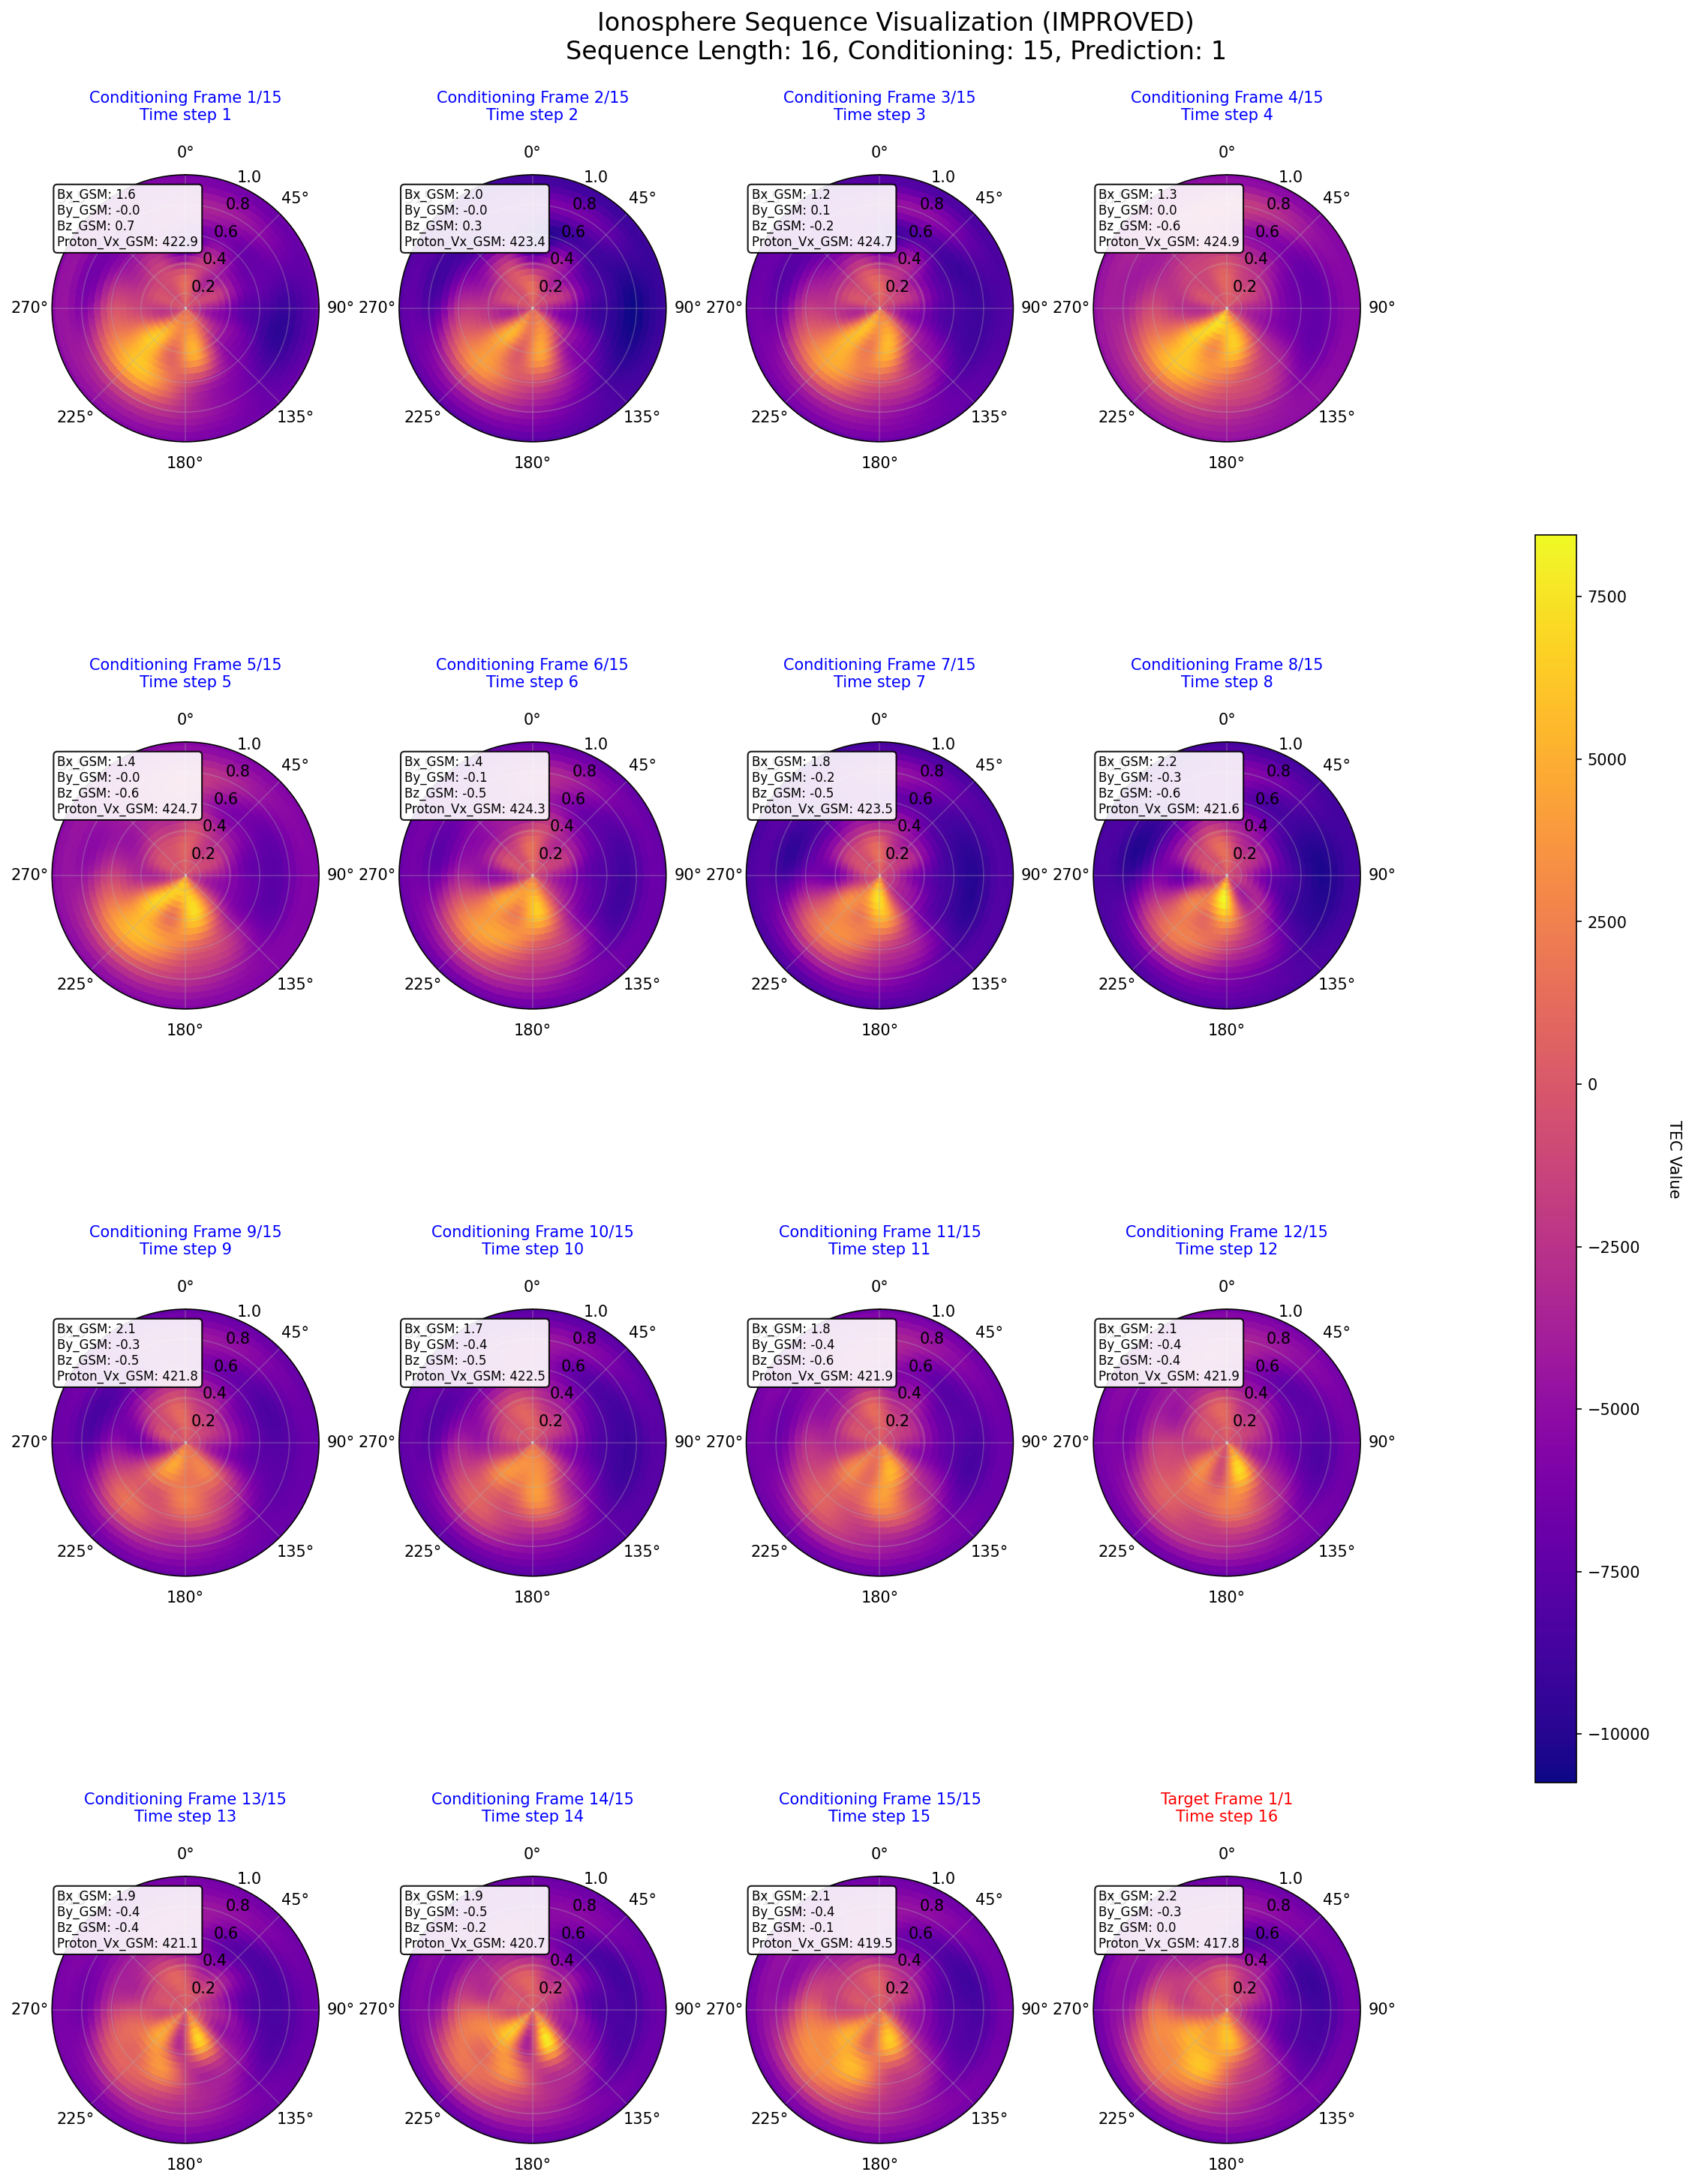

In [29]:
# Calculate grid dimensions
n_frames = SEQUENCE_LENGTH
n_cols = min(4, n_frames)  # Max 4 columns
n_rows = (n_frames + n_cols - 1) // n_cols  # Ceiling division

# Create subplots with polar projections - IMPROVED SPACING
fig = plt.figure(figsize=(5 * n_cols, 6 * n_rows))  # Increased height for better spacing

# Global min/max for consistent color scale
vmin, vmax = data_original.min().item(), data_original.max().item()

for i in range(n_frames):
    ax = fig.add_subplot(n_rows, n_cols, i + 1, projection='polar')
    
    # Get the frame data
    frame_data = data_original[i].numpy()  # Shape: [24, 360]
    
    # Create polar coordinates
    theta = np.linspace(0, 2*np.pi, frame_data.shape[1])  # 360 degrees
    r = np.linspace(0, 1, frame_data.shape[0])  # 24 radial bins
    
    # Create meshgrid for polar plot
    Theta, R = np.meshgrid(theta, r)
    
    # Plot - IMPROVED
    im = ax.pcolormesh(Theta, R, frame_data, cmap='plasma', vmin=vmin, vmax=vmax, shading='auto')
    
    # IMPROVED: Set title and formatting with better spacing
    if i < CONDITIONING_LENGTH:
        ax.set_title(f'Conditioning Frame {i+1}/{CONDITIONING_LENGTH}\nTime step {i+1}', 
                    pad=35, fontsize=10, color='blue')
    else:
        pred_step = i - CONDITIONING_LENGTH + 1
        ax.set_title(f'Target Frame {pred_step}/{PREDICT_STEPS}\nTime step {i+1}', 
                    pad=35, color='red', fontsize=10)
    
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    
    # FIXED: Remove white dot in center by starting from 0.1
    ax.set_ylim(0.1, 1)  # Start from 0.1 instead of 0
    ax.set_rticks([0.2, 0.4, 0.6, 0.8, 1.0])  # Custom radial ticks
    ax.grid(True, alpha=0.3)
    
    # Add conditions as text - IMPROVED positioning
    cond_text = f"{condition_names[0]}: {cond_original[i, 0]:.1f}\n"
    cond_text += f"{condition_names[1]}: {cond_original[i, 1]:.1f}\n"
    cond_text += f"{condition_names[2]}: {cond_original[i, 2]:.1f}\n"
    cond_text += f"{condition_names[3]}: {cond_original[i, 3]:.1f}"
    
    ax.text(0.02, 0.95, cond_text, transform=ax.transAxes, 
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9),
            verticalalignment='top', fontsize=8)

# IMPROVED: Better subplot spacing and colorbar
plt.subplots_adjust(hspace=0.5, wspace=0.3)  # More space between subplots
cbar = fig.colorbar(im, ax=fig.get_axes(), shrink=0.6, aspect=30, pad=0.1)
cbar.set_label('TEC Value', rotation=270, labelpad=20)

# IMPROVED: Lower main title to avoid overlap
plt.suptitle(f'Ionosphere Sequence Visualization (IMPROVED)\nSequence Length: {SEQUENCE_LENGTH}, Conditioning: {CONDITIONING_LENGTH}, Prediction: {PREDICT_STEPS}', 
             y=0.92, fontsize=16)  # Lowered from 0.98 to 0.92
plt.show()

## Visualize Conditions Over Time (IMPROVED)

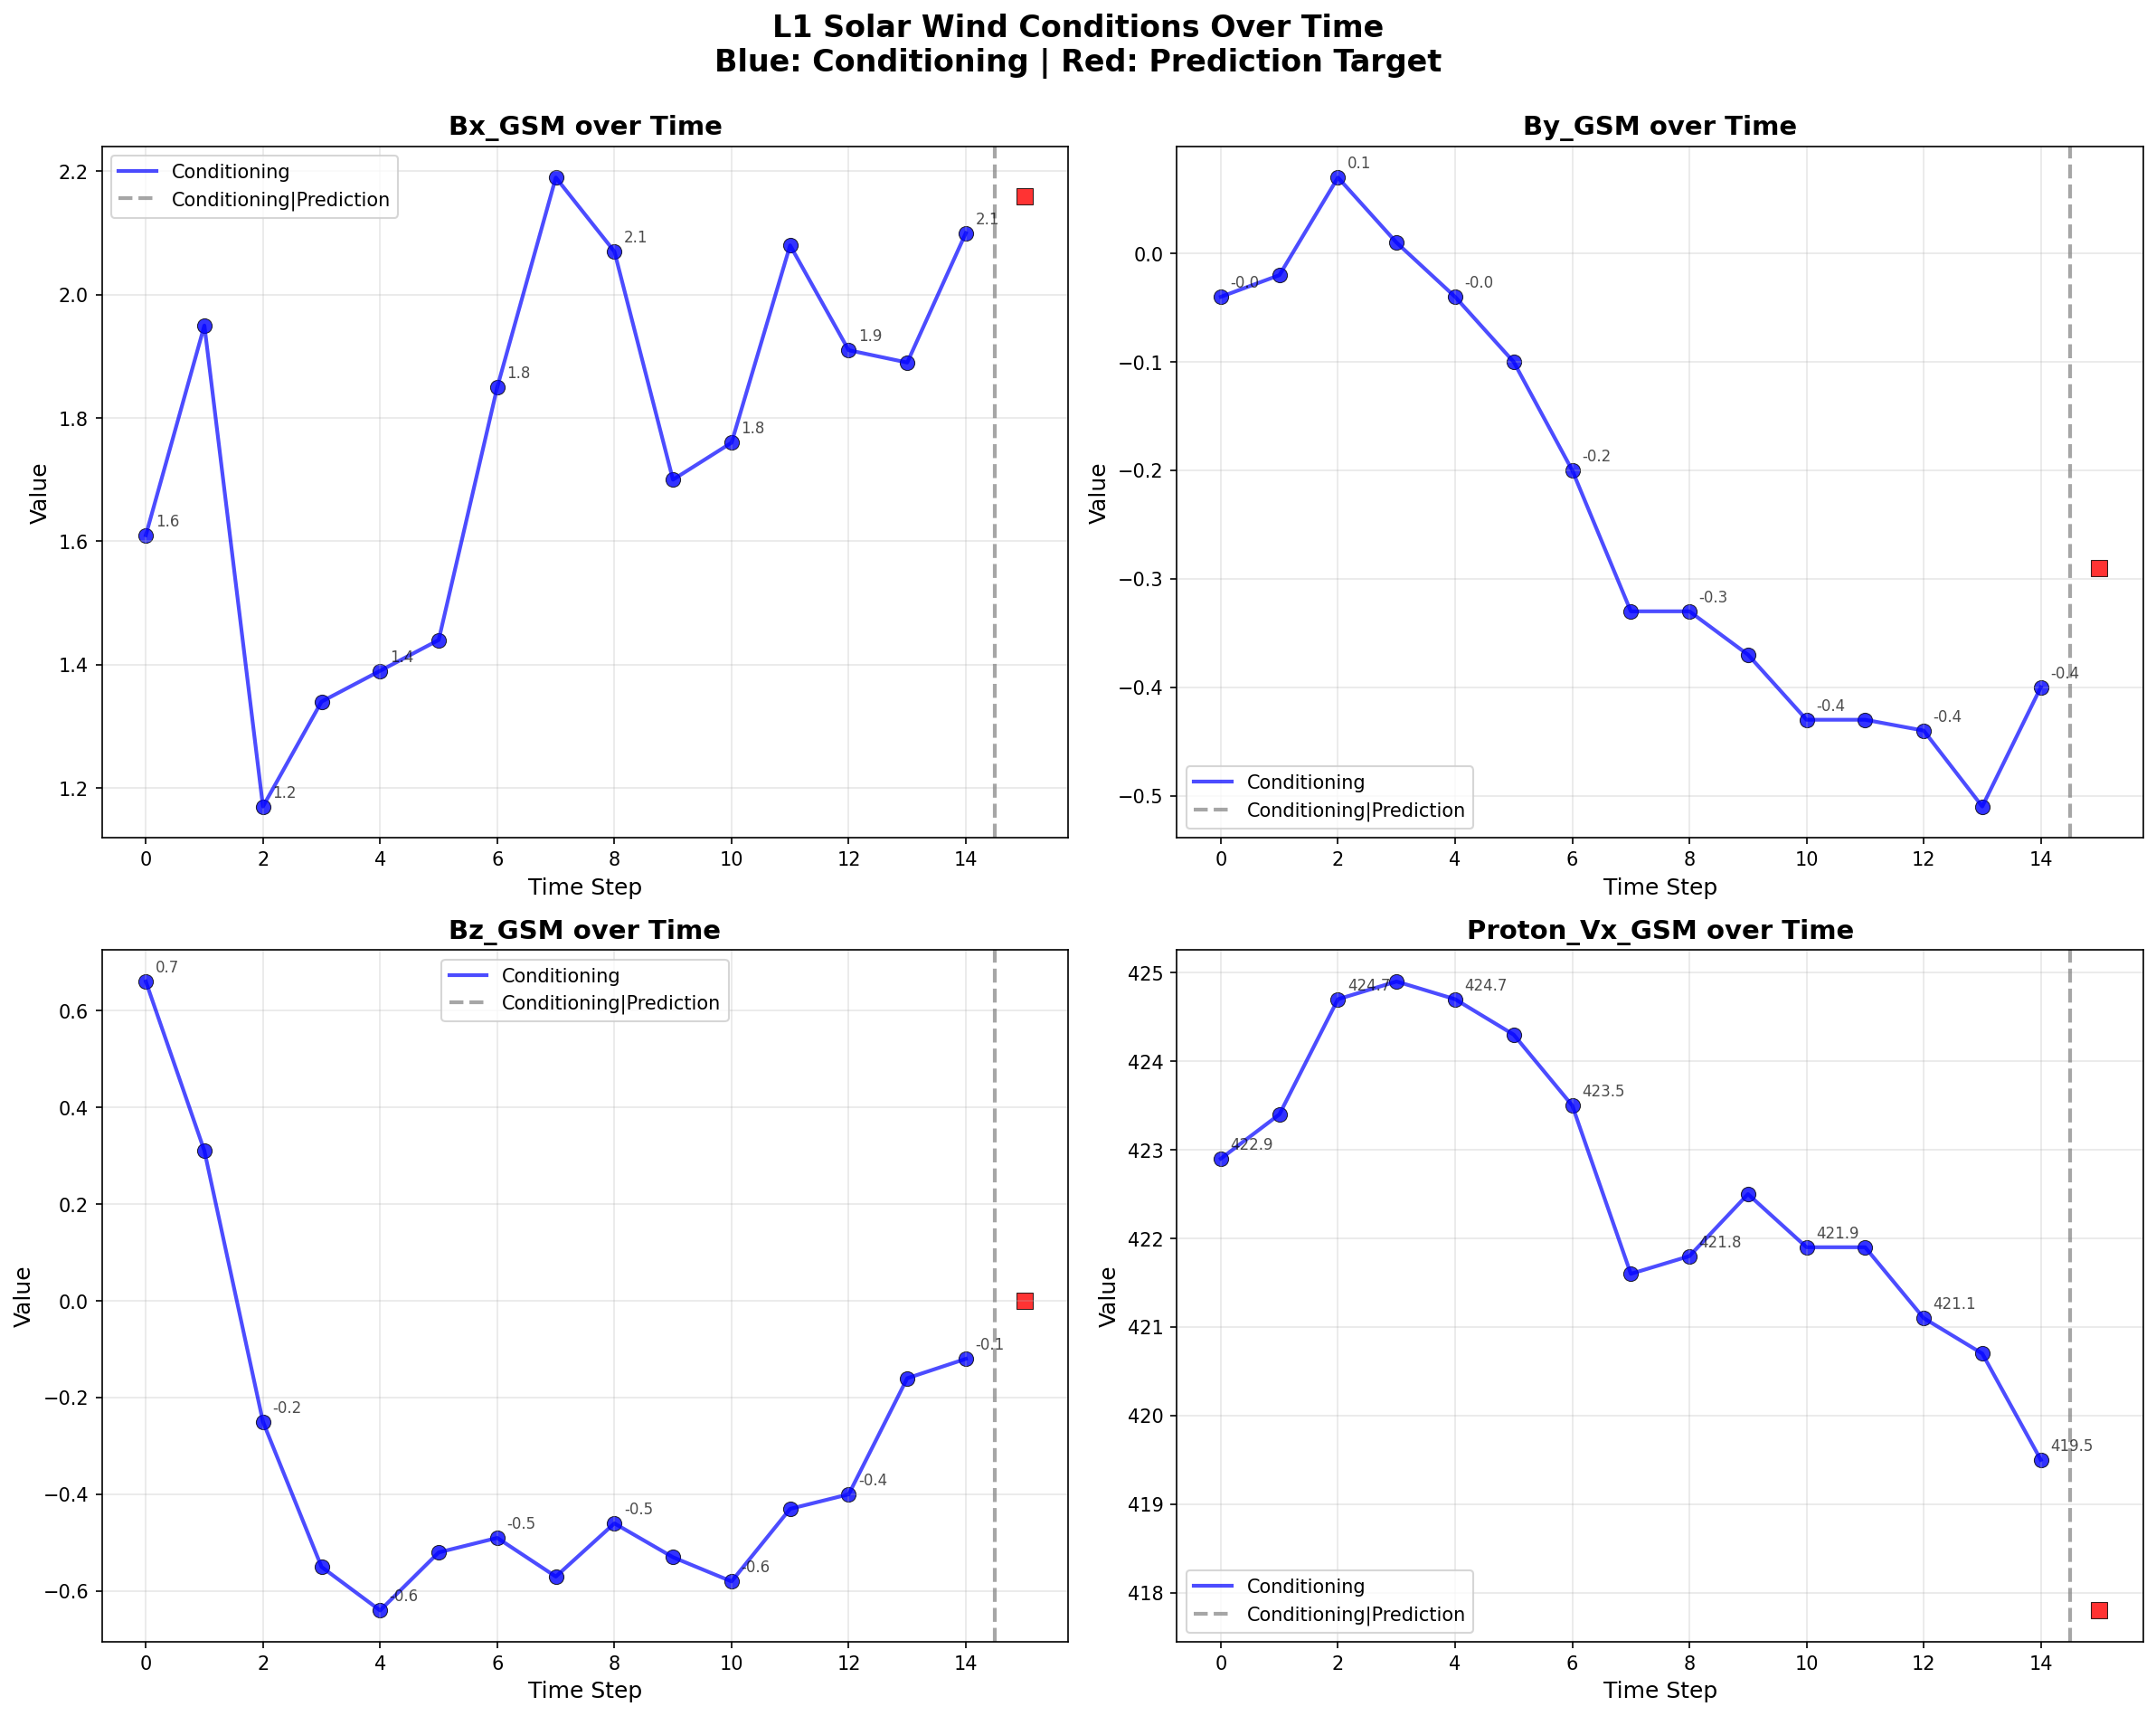

In [30]:
# Plot conditions over time - IMPROVED
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # Larger figure
axes = axes.flatten()

time_steps = np.arange(SEQUENCE_LENGTH)
colors = ['blue'] * CONDITIONING_LENGTH + ['red'] * PREDICT_STEPS

for i, (name, ax) in enumerate(zip(condition_names, axes)):
    values = cond_original[:, i].numpy()
    
    # Plot points with different colors for conditioning vs prediction
    for t in range(SEQUENCE_LENGTH):
        color = 'blue' if t < CONDITIONING_LENGTH else 'red'
        marker = 'o' if t < CONDITIONING_LENGTH else 's'
        size = 60 if t < CONDITIONING_LENGTH else 80
        ax.scatter(t, values[t], c=color, s=size, marker=marker, alpha=0.8, edgecolors='black', linewidth=0.5)
    
    # Connect points with lines
    ax.plot(time_steps[:CONDITIONING_LENGTH], values[:CONDITIONING_LENGTH], 'b-', alpha=0.7, linewidth=2, label='Conditioning')
    if PREDICT_STEPS > 1:
        ax.plot(time_steps[CONDITIONING_LENGTH-1:], values[CONDITIONING_LENGTH-1:], 'r-', alpha=0.7, linewidth=2, label='Prediction')
    
    ax.set_title(f'{name} over Time', fontsize=14, fontweight='bold')
    ax.set_xlabel('Time Step', fontsize=12)
    ax.set_ylabel('Value', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.axvline(x=CONDITIONING_LENGTH-0.5, color='gray', linestyle='--', alpha=0.7, linewidth=2, label='Conditioning|Prediction')
    ax.legend(loc='best', fontsize=10)
    
    # Add value annotations on points
    for t in range(0, SEQUENCE_LENGTH, max(1, SEQUENCE_LENGTH//8)):  # Annotate every few points
        ax.annotate(f'{values[t]:.1f}', (t, values[t]), 
                   xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)

plt.tight_layout()
plt.suptitle(f'L1 Solar Wind Conditions Over Time\nBlue: Conditioning | Red: Prediction Target', 
             y=1.05, fontsize=16, fontweight='bold')
plt.show()

## Create Dual Animation GIFs (NEW!)
Side-by-side animation: Polar plot + Condition plot

Creating dual animation (polar + 4 individual condition plots)...


/tmp/ipykernel_3643711/1488086293.py:23: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im = ax1.pcolormesh(Theta, R, frame_data, cmap='plasma', vmin=vmin, vmax=vmax, shading='auto')


Saving dual animation with 4 individual condition plots...
✅ Dual animation saved to /tmp/dual_sequence_animation.gif
🎬 Dual Animation: Polar Plot + 4 Individual Condition Plots


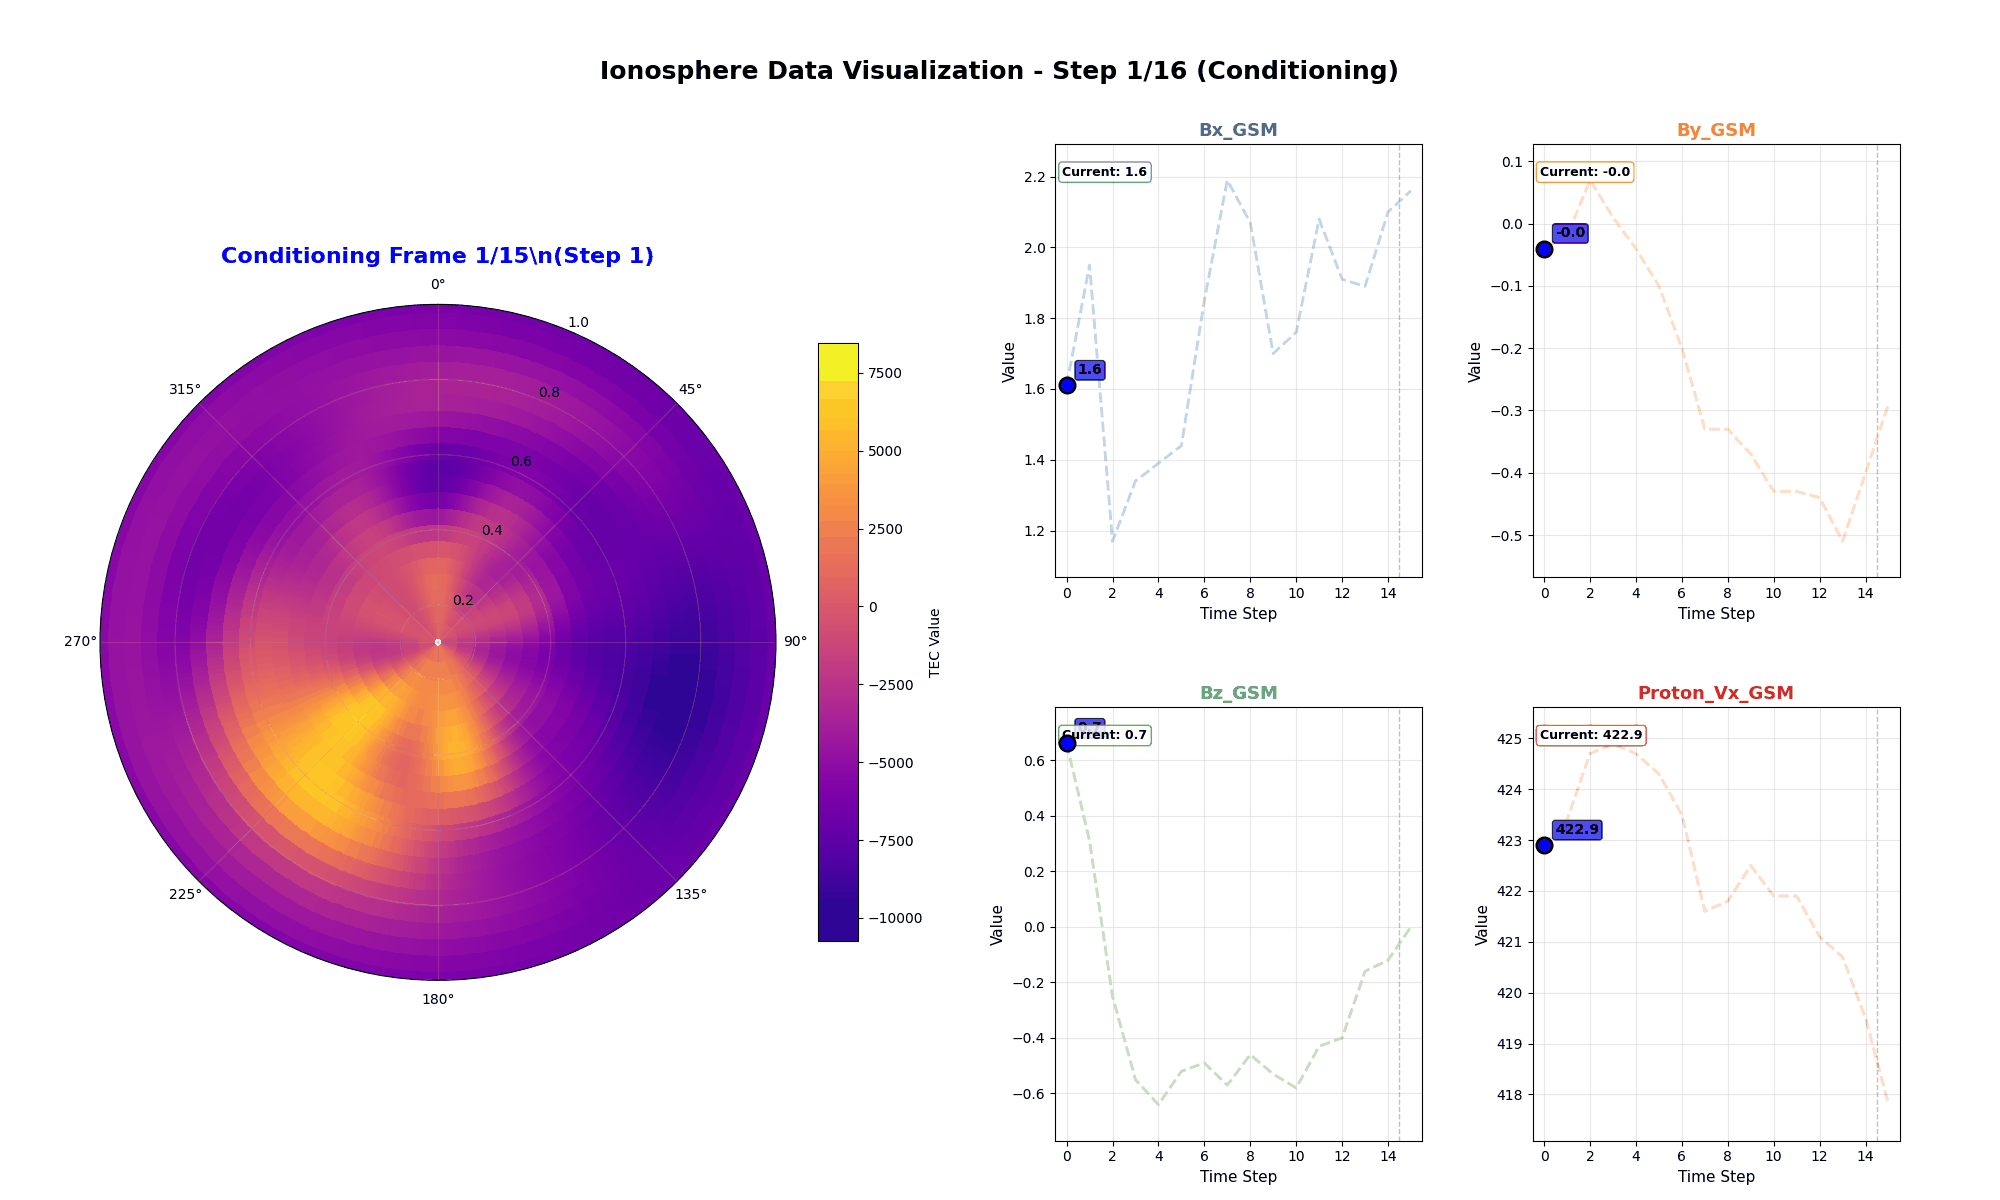

In [25]:
# Create dual animated GIF - Polar plot + 4 individual Condition plots
frames = []
temp_gif_path = '/tmp/dual_sequence_animation.gif'

print("Creating dual animation (polar + 4 individual condition plots)...")

for i in range(SEQUENCE_LENGTH):
    # Create figure with polar plot on left and 4 condition plots on right
    fig = plt.figure(figsize=(20, 12), dpi=100)  # Higher DPI for better quality
    
    # Left subplot: Polar plot (takes up left half)
    ax1 = plt.subplot2grid((2, 4), (0, 0), rowspan=2, colspan=2, projection='polar')
    
    # Get the frame data
    frame_data = data_original[i].numpy()  # Shape: [24, 360]
    
    # Create polar coordinates
    theta = np.linspace(0, 2*np.pi, frame_data.shape[1])
    r = np.linspace(0, 1, frame_data.shape[0])
    Theta, R = np.meshgrid(theta, r)
    
    # Plot polar - IMPROVED
    im = ax1.pcolormesh(Theta, R, frame_data, cmap='plasma', vmin=vmin, vmax=vmax, shading='auto')
    
    # Set title and formatting
    if i < CONDITIONING_LENGTH:
        title = f'Conditioning Frame {i+1}/{CONDITIONING_LENGTH}\\n(Step {i+1})'
        title_color = 'blue'
    else:
        pred_step = i - CONDITIONING_LENGTH + 1
        title = f'Target Frame {pred_step}/{PREDICT_STEPS}\\n(Step {i+1})'
        title_color = 'red'
    
    ax1.set_title(title, pad=30, color=title_color, fontsize=16, fontweight='bold')
    ax1.set_theta_zero_location('N')
    ax1.set_theta_direction(-1)
    ax1.set_ylim(0.1, 1)  # FIXED: No white dot
    ax1.set_rticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax1.grid(True, alpha=0.3)
    
    # Add colorbar for polar plot
    plt.colorbar(im, ax=ax1, shrink=0.6, aspect=15, label='TEC Value')
    
    # Right side: 4 individual condition plots (2x2 grid)
    colors_cond = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    time_steps = np.arange(SEQUENCE_LENGTH)
    
    # Create 4 subplots for conditions (2x2 grid on the right)
    condition_positions = [(0, 2), (0, 3), (1, 2), (1, 3)]  # (row, col) in right side
    
    for cond_idx, (name, color, pos) in enumerate(zip(condition_names, colors_cond, condition_positions)):
        ax_cond = plt.subplot2grid((2, 4), pos, colspan=1, rowspan=1)
        
        values = cond_original[:, cond_idx].numpy()
        
        # Plot full line (faded)
        ax_cond.plot(time_steps, values, color=color, alpha=0.3, linewidth=2, linestyle='--')
        
        # Plot up to current step (bright)
        ax_cond.plot(time_steps[:i+1], values[:i+1], color=color, alpha=1.0, linewidth=3)
        
        # Highlight current point
        current_color = 'blue' if i < CONDITIONING_LENGTH else 'red'
        ax_cond.scatter(i, values[i], color=current_color, s=120, marker='o', 
                       edgecolors='black', linewidth=2, zorder=10)
        
        # Add value annotation for current point
        ax_cond.annotate(f'{values[i]:.1f}', (i, values[i]), 
                        xytext=(8, 8), textcoords='offset points', 
                        fontsize=10, fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.2', facecolor=current_color, alpha=0.7, edgecolor='black'))
        
        # Formatting for each condition plot
        ax_cond.axvline(x=CONDITIONING_LENGTH-0.5, color='gray', linestyle='--', alpha=0.5, linewidth=1)
        ax_cond.set_xlim(-0.5, SEQUENCE_LENGTH-0.5)
        ax_cond.set_xlabel('Time Step', fontsize=11)
        ax_cond.set_ylabel('Value', fontsize=11)
        ax_cond.set_title(f'{name}', fontsize=13, fontweight='bold', color=color)
        ax_cond.grid(True, alpha=0.3)
        
        # Set y-limits with some padding
        y_min, y_max = values.min(), values.max()
        y_range = y_max - y_min
        if y_range > 0:
            ax_cond.set_ylim(y_min - 0.1*y_range, y_max + 0.1*y_range)
        else:
            ax_cond.set_ylim(y_min - 1, y_max + 1)  # fallback for constant values
        
        # Add current value text box
        current_val_text = f'Current: {values[i]:.1f}'
        ax_cond.text(0.02, 0.95, current_val_text, 
                     transform=ax_cond.transAxes,
                     bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor=color),
                     verticalalignment='top', fontsize=9, fontweight='bold')
    
    # Add overall step indicator
    step_text = f"Step {i+1}/{SEQUENCE_LENGTH}"
    step_type = "Conditioning" if i < CONDITIONING_LENGTH else "Prediction Target"
    fig.suptitle(f'Ionosphere Data Visualization - {step_text} ({step_type})', 
                fontsize=18, fontweight='bold', y=0.95)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.88, left=0.05, right=0.95, hspace=0.3, wspace=0.3)
    
    # Convert to image array - HIGHER QUALITY
    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(frame)
    
    plt.close(fig)

# Save as GIF with better quality
print("Saving dual animation with 4 individual condition plots...")
imageio.mimsave(temp_gif_path, frames, duration=500, loop=0)
print(f"✅ Dual animation saved to {temp_gif_path}")

# Display the GIF
print("🎬 Dual Animation: Polar Plot + 4 Individual Condition Plots")
display(Image(filename=temp_gif_path))

## Create Individual GIFs
Separate GIFs for polar plot and conditions (if you prefer them separately)

Creating improved polar plot GIF...


/tmp/ipykernel_3643711/3076185122.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im = ax.pcolormesh(Theta, R, frame_data, cmap='plasma', vmin=vmin, vmax=vmax, shading='auto')


✅ Polar animation saved to /tmp/polar_sequence.gif
Creating conditions GIF...
✅ Conditions animation saved to /tmp/conditions_sequence.gif

🎬 Individual GIFs:

📡 Polar Plot Animation:


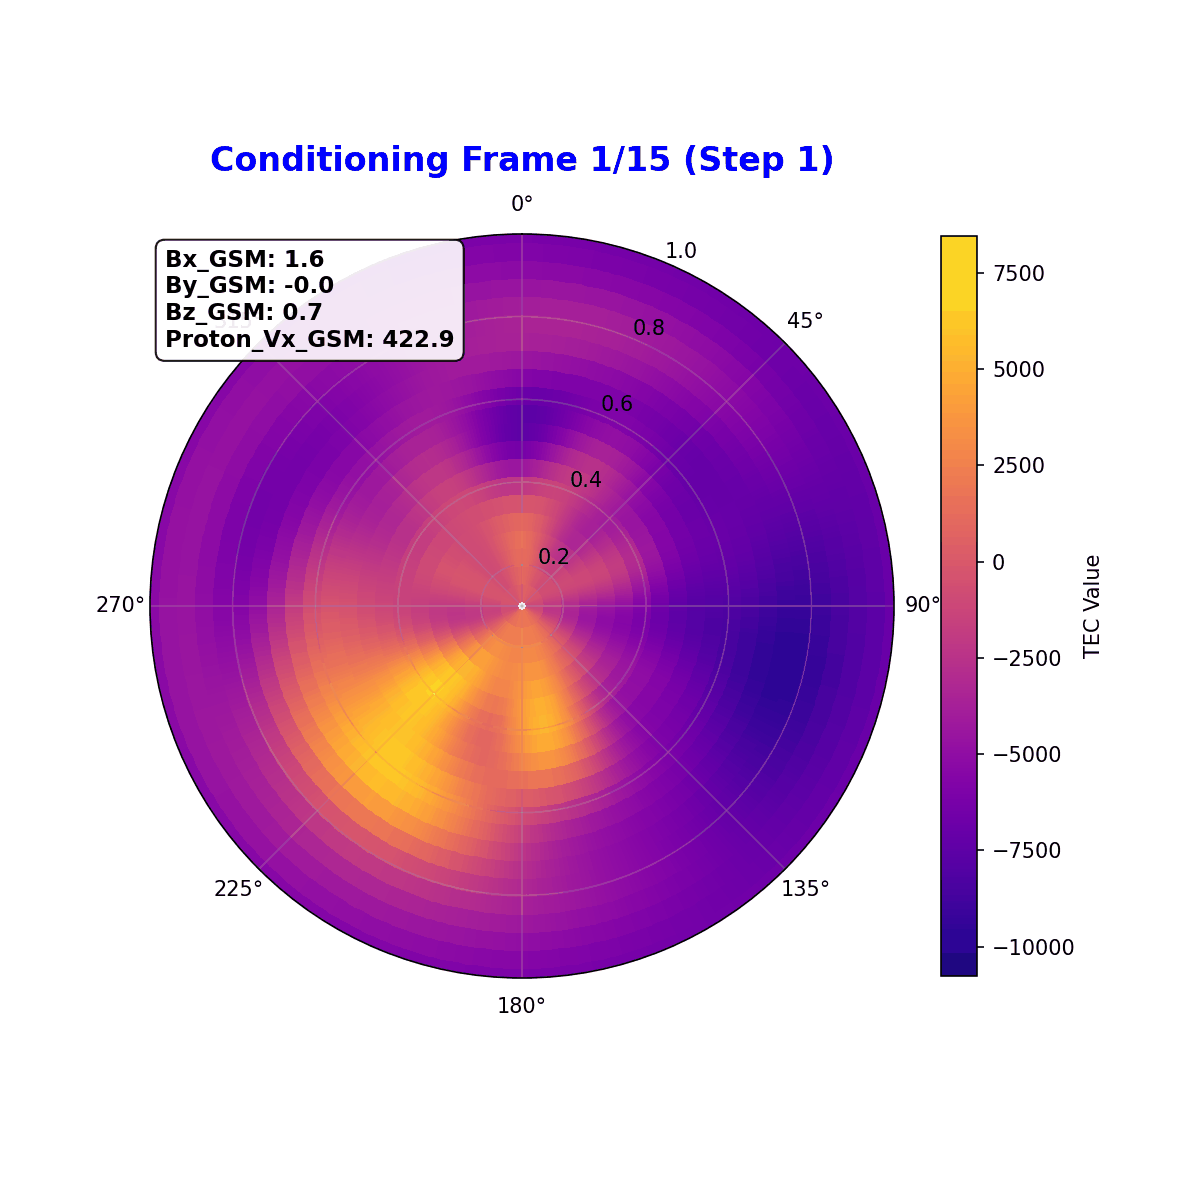


📈 Conditions Animation:


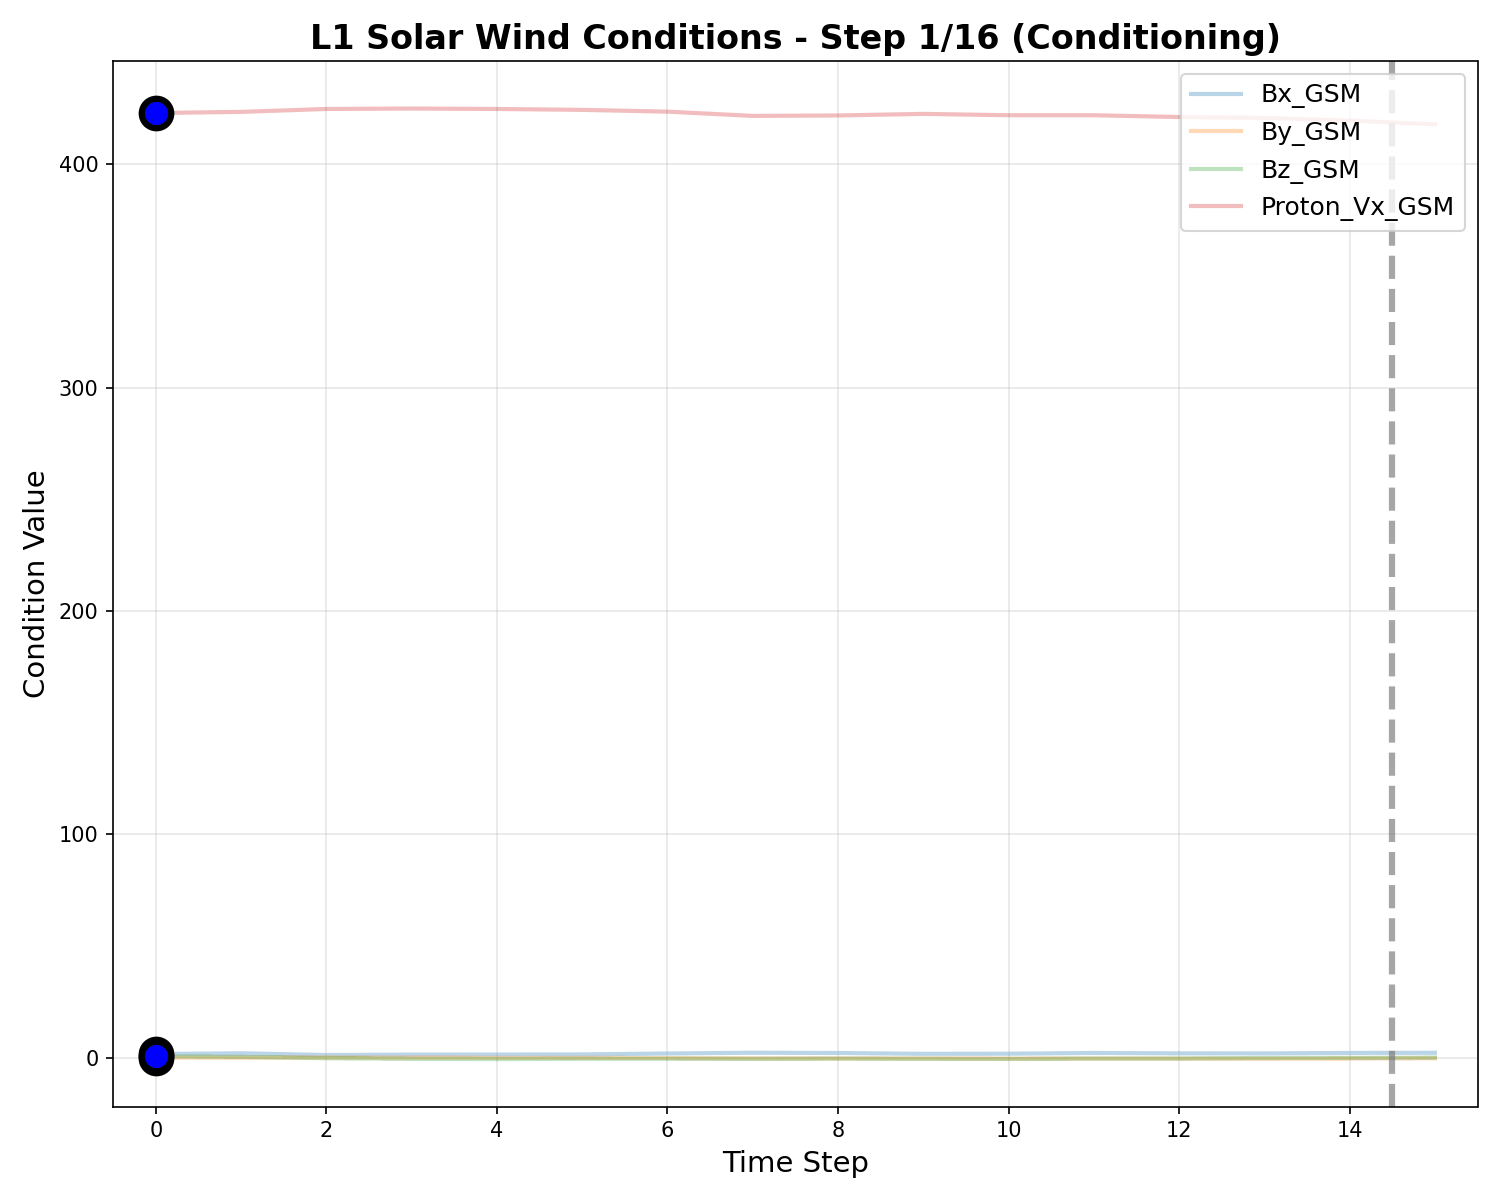

In [26]:
# Create separate polar plot GIF - IMPROVED
polar_frames = []
polar_gif_path = '/tmp/polar_sequence.gif'

print("Creating improved polar plot GIF...")

for i in range(SEQUENCE_LENGTH):
    # Create figure for this frame
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))
    
    # Get the frame data
    frame_data = data_original[i].numpy()  # Shape: [24, 360]
    
    # Create polar coordinates
    theta = np.linspace(0, 2*np.pi, frame_data.shape[1])
    r = np.linspace(0, 1, frame_data.shape[0])
    Theta, R = np.meshgrid(theta, r)
    
    # Plot - IMPROVED
    im = ax.pcolormesh(Theta, R, frame_data, cmap='plasma', vmin=vmin, vmax=vmax, shading='auto')
    
    # Set title and formatting
    if i < CONDITIONING_LENGTH:
        title = f'Conditioning Frame {i+1}/{CONDITIONING_LENGTH} (Step {i+1})'
        title_color = 'blue'
    else:
        pred_step = i - CONDITIONING_LENGTH + 1
        title = f'Target Frame {pred_step}/{PREDICT_STEPS} (Step {i+1})'
        title_color = 'red'
    
    ax.set_title(title, pad=30, color=title_color, fontsize=16, fontweight='bold')
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_ylim(0.1, 1)  # FIXED: No white dot
    ax.set_rticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.grid(True, alpha=0.3)
    
    # Add conditions
    cond_text = f"{condition_names[0]}: {cond_original[i, 0]:.1f}\n"
    cond_text += f"{condition_names[1]}: {cond_original[i, 1]:.1f}\n"
    cond_text += f"{condition_names[2]}: {cond_original[i, 2]:.1f}\n"
    cond_text += f"{condition_names[3]}: {cond_original[i, 3]:.1f}"
    
    ax.text(0.02, 0.98, cond_text, transform=ax.transAxes,
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.9),
            verticalalignment='top', fontsize=11, fontweight='bold')
    
    # Add colorbar
    plt.colorbar(im, ax=ax, shrink=0.8, aspect=20, label='TEC Value')
    
    # Convert to image array
    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    polar_frames.append(frame)
    
    plt.close(fig)

# Save polar GIF
imageio.mimsave(polar_gif_path, polar_frames, duration=0.8, loop=0)
print(f"✅ Polar animation saved to {polar_gif_path}")

# Create conditions-only GIF
cond_frames = []
cond_gif_path = '/tmp/conditions_sequence.gif'

print("Creating conditions GIF...")

for i in range(SEQUENCE_LENGTH):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    time_steps = np.arange(SEQUENCE_LENGTH)
    colors_cond = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    for cond_idx, (name, color) in enumerate(zip(condition_names, colors_cond)):
        values = cond_original[:, cond_idx].numpy()
        
        # Plot full line (faded)
        ax.plot(time_steps, values, color=color, alpha=0.3, linewidth=2, label=name)
        
        # Plot up to current step (bright)
        ax.plot(time_steps[:i+1], values[:i+1], color=color, alpha=1.0, linewidth=4)
        
        # Highlight current point
        current_color = 'blue' if i < CONDITIONING_LENGTH else 'red'
        ax.scatter(i, values[i], color=current_color, s=200, marker='o', 
                  edgecolors='black', linewidth=3, zorder=10)
    
    ax.axvline(x=CONDITIONING_LENGTH-0.5, color='gray', linestyle='--', alpha=0.7, linewidth=3)
    ax.set_xlim(-0.5, SEQUENCE_LENGTH-0.5)
    ax.set_xlabel('Time Step', fontsize=14)
    ax.set_ylabel('Condition Value', fontsize=14)
    
    step_type = "Conditioning" if i < CONDITIONING_LENGTH else "Prediction Target"
    ax.set_title(f'L1 Solar Wind Conditions - Step {i+1}/{SEQUENCE_LENGTH} ({step_type})', 
                fontsize=16, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=12)
    
    plt.tight_layout()
    
    # Convert to image array
    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    cond_frames.append(frame)
    
    plt.close(fig)

# Save conditions GIF
imageio.mimsave(cond_gif_path, cond_frames, duration=0.8, loop=0)
print(f"✅ Conditions animation saved to {cond_gif_path}")

# Display both individual GIFs
print("\n🎬 Individual GIFs:")
print("\n📡 Polar Plot Animation:")
display(Image(filename=polar_gif_path))
print("\n📈 Conditions Animation:")
display(Image(filename=cond_gif_path))

## Statistics and Information

In [ ]:
# Print dataset statistics
print("📊 Dataset Statistics:")
print(f"  Total sequences: {len(train_dataset)}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Number of batches: {len(train_dl)}")

print(f"\n📏 Data Statistics:")
print(f"  Original data range: {data_original.min():.2f} to {data_original.max():.2f}")
print(f"  Data mean: {data_original.mean():.2f}")
print(f"  Data std: {data_original.std():.2f}")

print(f"\n🌤️ Condition Statistics:")
for i, name in enumerate(condition_names):
    cond_values = cond_original[:, i]
    print(f"  {name}:")
    print(f"    Range: {cond_values.min():.2f} to {cond_values.max():.2f}")
    print(f"    Mean: {cond_values.mean():.2f}")
    print(f"    Std: {cond_values.std():.2f}")

print(f"\n🔧 Configuration Summary:")
print(f"  Using L1 conditions: {USE_L1_CONDITIONS}")
print(f"  Normalization type: {NORM_TYPE}")
print(f"  Sequence length: {SEQUENCE_LENGTH}")
print(f"  Conditioning frames: {CONDITIONING_LENGTH}")
print(f"  Prediction frames: {PREDICT_STEPS}")
print(f"  CSV path: {CSV_PATH}")

print(f"\n✨ Improvements in this notebook:")
print(f"  ✅ Fixed white dot in polar plots (set ylim to start from 0.1)")
print(f"  ✅ Improved title spacing (increased pad and adjusted subplot spacing)")
print(f"  ✅ Added dual GIF animation (polar + conditions side-by-side)")
print(f"  ✅ Enhanced condition plots with better annotations and colors")
print(f"  ✅ Separate GIFs for polar plots and conditions")

## Explore More Samples (IMPROVED)

In [ ]:
# IMPROVED function to visualize any sample from the dataset
def visualize_sample(sample_idx, save_gif=False):
    """
    Visualize a specific sample from the dataset - IMPROVED
    
    Args:
        sample_idx: Index of the sample to visualize
        save_gif: Whether to save an animated GIF
    """
    # Get sample
    data_seq, cond_seq = train_dataset[sample_idx]
    
    # Reverse normalization
    if NORM_TYPE == "absolute_max":
        data_original = data_seq.squeeze(1) * 55000.0
    else:
        data_original = train_dataset.reverse_data_normalization(data_seq.squeeze(1))
    
    cond_original = train_dataset.revert_condition_normalization(cond_seq)
    
    # IMPROVED: Quick overview plot with better formatting
    n_show = min(4, SEQUENCE_LENGTH)
    fig, axes = plt.subplots(1, n_show, figsize=(5*n_show, 6), subplot_kw=dict(projection='polar'))
    if n_show == 1:
        axes = [axes]
    
    vmin, vmax = data_original.min().item(), data_original.max().item()
    
    for i, ax in enumerate(axes):
        if i >= SEQUENCE_LENGTH:
            break
            
        frame_data = data_original[i].numpy()
        theta = np.linspace(0, 2*np.pi, frame_data.shape[1])
        r = np.linspace(0, 1, frame_data.shape[0])
        Theta, R = np.meshgrid(theta, r)
        
        im = ax.pcolormesh(Theta, R, frame_data, cmap='plasma', vmin=vmin, vmax=vmax, shading='auto')
        
        if i < CONDITIONING_LENGTH:
            ax.set_title(f'Cond {i+1}', color='blue', fontsize=12, pad=20)
        else:
            ax.set_title(f'Target {i-CONDITIONING_LENGTH+1}', color='red', fontsize=12, pad=20)
        
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)
        ax.set_ylim(0.1, 1)  # FIXED: No white dot
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'Sample {sample_idx} Overview (IMPROVED)', fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()
    
    # Print condition info
    print(f"Sample {sample_idx} Conditions:")
    for i, name in enumerate(condition_names):
        values = cond_original[:, i]
        print(f"  {name}: {values.min():.2f} to {values.max():.2f} (mean: {values.mean():.2f})")

# Example: visualize sample 0 (already done above), 1, 2, etc.
print("To visualize a different sample, call: visualize_sample(sample_index)")
print(f"Available samples: 0 to {len(train_dataset)-1}")
print("\nTry: visualize_sample(1), visualize_sample(2), etc.")

In [ ]:
# Visualize a few more samples - IMPROVED
for i in [1, 2]:
    if i < len(train_dataset):
        print(f"\n{'='*50}")
        print(f"--- Sample {i} (IMPROVED) ---")
        print(f"{'='*50}")
        visualize_sample(i)